The accompanying notebook for the **"How We Optimize Hyperparmeters At Qucit"** blog post

# Load libraries and set constants

## Load libraries

In [2]:
# Data analysis imports
import pandas as pd
import numpy as np

# Machine learning imports
import xgboost as xgb
import sklearn
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

# Hyperopt imports
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, rand

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [28]:
pd.set_option('max_colwidth',100)
sns.set(font_scale=1.5)

## Some constants

In [4]:
SEED = 314
TEST_SIZE = 0.2
MAX_EVALS = 10

## Hyperparameters grids

In [5]:
gs_hp_grid = {'max_depth':[4, 6, 8, 10],
              'n_estimators': [10, 15, 20, 25],
              'learning_rate': [0.2, 0.4, 0.6, 0.8], 
              'gamma': [0.2, 0.4, 0.6, 0.8]
}

hyperopt_hp_grid = {'n_estimators' : hp.quniform('n_estimators', 10, 1000, 1),
             'learning_rate' : hp.loguniform('learning_rate', 0.001, 0.1),
             'max_depth' : hp.quniform('max_depth', 3, 15, 1),
             'gamma': hp.loguniform('gamma', 0.01, 1)}

# Some utiliy functions 

## Score

In [6]:
mse_scorer = make_scorer(mean_squared_error)

## Data loading

In [7]:
def load_car_accidents():
    accidents_df = pd.read_csv('../data/accident.csv')
    features = accidents_df.drop('FATALS', axis=1)
    # Don't select the columns having object type
    columns = features.columns[features.dtypes != 'object']
    targets = accidents_df[['FATALS']]
    return features.loc[:, columns], targets

## Grid search 

In [8]:
def compute_rmse(model, features, targets):
    prediction = model.predict(features)
    rmse = np.sqrt(mean_squared_error(targets, prediction))
    return rmse

def train_grid_search(cv_parameters, features, targets):
    xgb_regressor = xgb.XGBRegressor({'eval_score':'rmse'})
    grid_search = GridSearchCV(xgb_regressor, cv_parameters, cv=5, 
                               verbose=1, 
                               n_jobs=4, scoring=mse_scorer)
    grid_search.fit(features, targets)
    return grid_search

## Hyperopt

In [9]:
def transform_params(params):
    params["gamma"] = np.log(params["gamma"])
    params["learning_rate"] = np.log(params["learning_rate"])
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    return params

In [10]:
def loss(params):
    params = transform_params(params)
    xgb_regressor = xgb.XGBRegressor(silent=False, **params)
    cv_mse = cross_val_score(xgb_regressor, train_features, train_targets, 
                          cv=5, verbose=0, n_jobs=4, 
                          scoring=mse_scorer)
    rmse = np.sqrt(cv_mse.mean())
    return {'loss': rmse, 
            'status': STATUS_OK}
def optimize(trials, space):
    best = fmin(loss, space, algo=tpe.suggest, 
                trials=trials, 
                max_evals=MAX_EVALS)
    return best
def random_optimize(trials, space):
    best = fmin(loss, space, algo=rand.suggest,
                trials=trials, 
                max_evals=MAX_EVALS)
    return best

## Model results

In [11]:
def get_model_results(hyperparameters):
    xgb_regressor = xgb.XGBRegressor(**hyperparameters)
    mse_cv_scores = cross_val_score(xgb_regressor, train_features, train_targets, 
                                cv=5, verbose=0, 
                                n_jobs=4, scoring=mse_scorer)
    rmse_cv_scores = np.sqrt(mse_cv_scores)
    xgb_regressor.fit(train_features, train_targets)
    train_rmse = compute_rmse(xgb_regressor, train_features, train_targets)
    test_rmse = compute_rmse(xgb_regressor, test_features, test_targets)
    return {'optimal_hyperparameters': hyperparameters,
            'train_rmse': train_rmse,
            'mean_cv_rmse' : np.sqrt(mse_cv_scores.mean()),
            'std_cv_rmse':  mse_cv_scores.std() / float(np.sqrt(len(mse_cv_scores))),
            'test_rmse': test_rmse}

# Load data and train/test split

In [12]:
features, targets = load_car_accidents()

In [13]:
train_features, test_features, train_targets, test_targets = train_test_split(features, targets, 
                                                                              test_size=TEST_SIZE, 
                                                                              random_state=SEED)

## Explore targets 

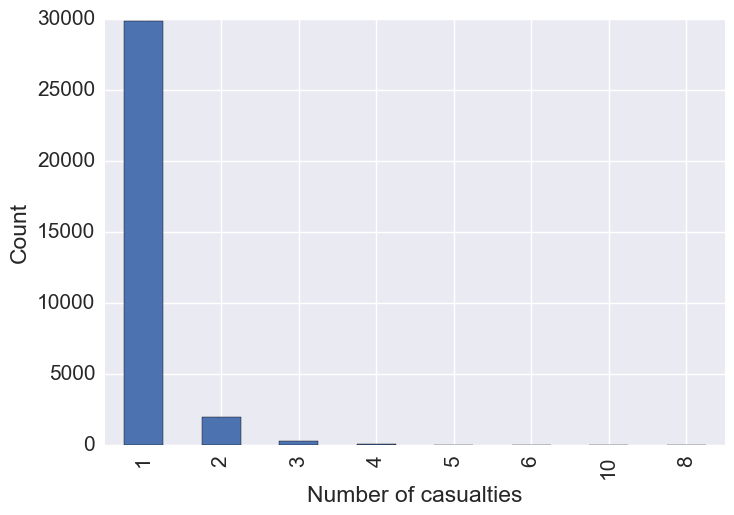

In [30]:
ax = targets.FATALS.value_counts().plot(kind='bar')
ax.set_xlabel('Number of casualties')
ax.set_ylabel('Count')

# Optimize hyperparameters

## Grid search

In [31]:
grid_search = train_grid_search(gs_hp_grid, train_features, train_targets)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 11.7min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 20.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 31.7min
[Parallel(n_jobs=4)]: Done 1280 out of 1280 | elapsed: 32.9min finished


## Random search

In [32]:
random_trials = Trials()
random_optimal_hp = random_optimize(random_trials, hyperopt_hp_grid)

In [33]:
random_optimal_hp = transform_params(random_optimal_hp)

## TPE search

In [159]:
trials = Trials()
hyperopt_optimal_hp = optimize(trials, hyperopt_hp_grid)

In [ ]:
hyperopt_optimal_hp = transform_params(hyperopt_optimal_hp)

## Results

In [165]:
def get_results_df():
    optimization_methods = ['grid_search', 'random_search', 'hyperopt_tpe']
    optimal_hyperparameters= [grid_search.best_params_, 
                              random_optimal_hp,
                              hyperopt_optimal_hp]
    results = [get_model_results(optimal_hp) for optimal_hp in optimal_hyperparameters]
    return (pd.DataFrame(results)
              .assign(opt_method=lambda df: pd.Series(optimization_methods))
              .loc[:, 
                   ['optimal_hyperparameters', 'test_rmse', 
                    'mean_cv_rmse', 'std_cv_rmse', 
                    'train_rmse', 'opt_method']])

In [166]:
results_df = get_results_df()

In [167]:
results_df

,optimal_hyperparameters,test_rmse,mean_cv_rmse,std_cv_rmse,train_rmse,opt_method
0,"{u'n_estimators': 25, u'learning_rate': 0.8, u'max_depth': 10, u'gamma': 0.2}",0.390102,0.406295,0.001396,0.138684,grid_search
1,"{u'n_estimators': 105, u'learning_rate': 0.0583873644628, u'max_depth': 5, u'gamma': 0.555704565...",0.325454,0.338373,0.003867,0.302278,random_search
2,"{u'n_estimators': 721, u'learning_rate': 0.0812468270757, u'max_depth': 4, u'gamma': 0.640681919...",0.325325,0.338179,0.003728,0.298393,hyperopt_tpe


## Save results

In [169]:
results_df.to_csv('../data/accidents_opt_hp_results.csv', index=False)

## Formatting the results into a HTML table


In [168]:
from IPython.display import HTML
results_df.to_html().replace('\n','')

u'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>optimal_hyperparameters</th>      <th>test_rmse</th>      <th>mean_cv_rmse</th>      <th>std_cv_rmse</th>      <th>train_rmse</th>      <th>opt_method</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>{u\'n_estimators\': 25, u\'learning_rate\': 0.8, u\'max_depth\': 10, u\'gamma\': 0.2}</td>      <td>0.390102</td>      <td>0.406295</td>      <td>0.001396</td>      <td>0.138684</td>      <td>grid_search</td>    </tr>    <tr>      <th>1</th>      <td>{u\'n_estimators\': 105, u\'learning_rate\': 0.0583873644628, u\'max_depth\': 5, u\'gamma\': 0.555704565...</td>      <td>0.325454</td>      <td>0.338373</td>      <td>0.003867</td>      <td>0.302278</td>      <td>random_search</td>    </tr>    <tr>      <th>2</th>      <td>{u\'n_estimators\': 721, u\'learning_rate\': 0.0812468270757, u\'max_depth\': 4, u\'gamma\': 0.640681919...</td>      <td>0.325325</td>      <td>0.338